In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2016,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
                       ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
                       ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolios = []
# portfolios.append(portfolio)
portfolios.append(portfolio_ii)
# portfolios.append(portfolio_iii)
# portfolios.append(portfolio_iv)
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
fund.initialize_portfolios()

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [7]:
bench_returns

,year,week,adjclose,quarter,day,bench_weekly_return,quarter_start,bench_quarterly_return,weekly_variance,quarterly_variance
14,2013,40,1696.49,3.0,4.0,-0.009077,1619.09,0.047805,0.000181,0.000425
15,2013,41,1687.92,4.0,4.0,-0.005052,1687.92,0.000000,0.000162,0.000341
16,2013,42,1676.75,4.0,4.0,-0.006618,1687.92,-0.006618,0.000161,0.000376
17,2013,43,1721.48,4.0,4.0,0.026677,1687.92,0.019882,0.000166,0.000383
18,2013,44,1751.51,4.0,4.0,0.017444,1687.92,0.037674,0.000172,0.000379
...,...,...,...,...,...,...,...,...,...,...
517,2023,21,4159.00,2.0,4.0,0.007039,4105.13,0.013123,0.000164,0.000446
518,2023,22,4162.04,2.0,4.0,0.000731,4105.13,0.013863,0.000164,0.000248
519,2023,23,4222.19,2.0,4.0,0.014452,4105.13,0.028516,0.000092,0.000224
520,2023,24,4283.59,2.0,4.0,0.014542,4105.13,0.043472,0.000097,0.000247


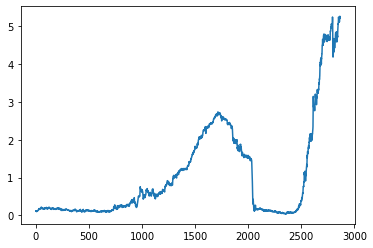

In [8]:
plt.plot(tyields["value"])

In [9]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("historical_trades")
    trade["positions"] = int(portfolio.pricer_class.positions / 2)
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [10]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [11]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,short_returns,returns,position,actual_returns,value,...,classification,rank,short,market_return,buy_day,sell_day,risk,positions,portfolio,pricer_timeframe
0,2016,5,PKG,0.045851,1.0,1.002004,0.983971,0,0.983971,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
1,2016,6,NVR,0.140525,1.0,0.996329,1.002497,0,1.002497,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
2,2016,7,NVR,0.131692,1.0,1.040349,1.020213,0,1.020213,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
3,2016,8,WYNN,0.126063,1.0,1.031638,1.060264,0,1.060264,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
4,2016,9,FCX,0.144796,1.0,1.259021,1.207474,0,1.207474,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6539,2022,47,OTIS,0.026344,1.0,0.977125,0.981597,19,0.981597,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
6540,2022,48,IT,0.019812,1.0,1.023289,1.027876,19,1.027876,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
6541,2022,49,WELL,0.034654,1.0,0.977859,0.994428,19,0.994428,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week
6542,2022,50,EL,0.038633,1.0,0.968972,0.944350,19,0.944350,True,...,False,False,False,1.15,1,5,True,10,wss_wssc_wsrr_b_r,week


In [12]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [13]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [14]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'portfolio',
 'pricer_timeframe']

In [15]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.81it/s]


In [16]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
334,True,True,False,False,False,1.15,1,5,True,wss_wssc_wsrr_b_r,week,3.242772,0.027639,1.029151,81.109488


In [17]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,pricer_timeframe,pv,beta,rrr,sharpe
0,wss_wssc_wsrr_b_r,True,True,False,False,False,1.15,1,5,True,week,3.242772,0.027639,1.029151,81.109488


In [18]:
top = a[a["portfolio"]=="wss_wssc_wsrr_b_r"].sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

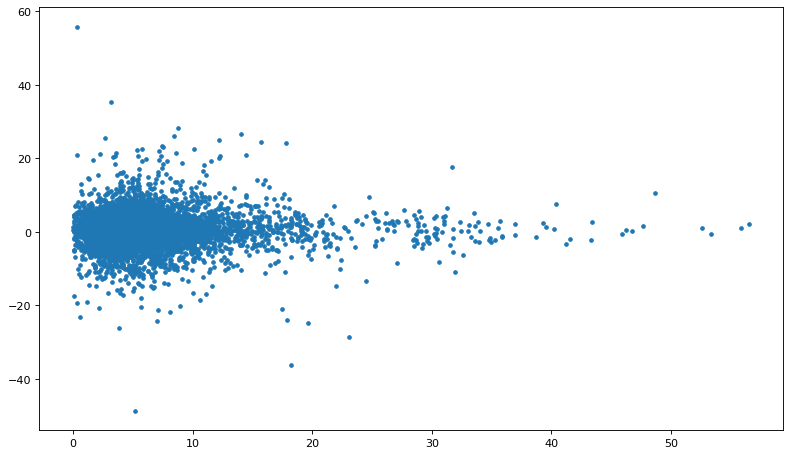

In [19]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [20]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2016,5,PKG,0.045851,1.0,0.983971,0,Materials,Packaging Corporation of America
335,2016,5,BSX,0.035099,1.0,0.920404,1,Health Care,Boston Scientific
669,2016,5,ED,0.030547,1.0,1.028121,2,Utilities,Consolidated Edison
1003,2016,5,CPB,0.028963,1.0,0.990055,3,Consumer Staples,Campbell Soup Company
1337,2016,5,TFX,0.023432,1.0,0.964944,4,Health Care,Teleflex
1669,2016,5,WBA,0.015146,1.0,0.930128,5,Consumer Staples,Walgreens Boots Alliance
2001,2016,5,DAL,0.009936,1.0,0.925247,6,Industrials,Delta Air Lines
2333,2016,5,IPGP,0.009664,1.0,1.005504,7,Information Technology,IPG Photonics
2663,2016,5,IP,0.002629,1.0,1.004430,8,Materials,International Paper
2991,2016,5,LMT,0.000062,1.0,1.012687,9,Industrials,Lockheed Martin


In [21]:
ledger["actual_returns"].mean()

1.0048204526293725

In [22]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5641809290953546

In [23]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [24]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2016,5,0.983971,0.920404,1.028121,0.990055,0.964944,0.930128,0.925247,1.005504,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2016,6,1.002497,0.990812,1.030646,1.005184,0.987013,1.070792,1.044011,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2016,7,1.020213,1.026971,1.074700,1.028925,1.027281,1.049830,0.999331,1.027090,...,1.035745,1.011002,1.057152,1.037550,1.024836,1.019772,1.084071,1.026144,1.023296,1.024666
3,2016,8,1.060264,1.096157,1.017196,0.904153,1.097132,1.007412,1.029564,1.022664,...,0.979036,1.103378,1.040419,1.031398,1.037900,1.045155,1.043288,1.045217,1.012702,1.011555
4,2016,9,1.207474,1.010759,0.990802,0.985732,0.964912,1.045776,1.070028,0.982606,...,1.012186,1.014230,1.102234,0.994374,0.996715,1.079667,0.991913,1.032728,0.984499,1.017850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2022,48,1.025194,1.020266,1.023254,1.019837,1.000238,1.070744,1.009057,0.907151,...,0.980320,0.995827,1.069413,0.990967,0.994872,0.995464,1.015807,0.874934,0.938804,1.027876
331,2022,49,1.074152,1.025274,1.003756,1.053075,1.035117,1.032258,1.071618,1.025406,...,0.992534,1.017908,1.070189,1.071064,1.067389,1.018154,1.012105,1.048291,0.990854,0.994428
332,2022,50,0.981685,0.901328,0.850155,0.915374,0.888889,0.970258,0.957580,0.905312,...,1.001599,0.970531,0.958697,0.951620,0.963843,0.931806,0.956978,0.930066,0.962419,0.944350
333,2022,51,1.053135,1.021221,1.040711,0.996837,1.005470,1.001853,1.030327,1.011855,...,1.011805,1.032020,1.028323,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [26]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,0.983971,0.920404,1.028121,0.990055,0.964944,0.930128,0.925247,1.005504,1.004430,1.012687,2016,5,0.976549,1899.45,1.000000,2016-W5,2016-02-05
1,0.986428,0.911947,1.059629,0.995188,0.952413,0.995974,0.965968,1.005504,1.004430,1.012687,2016,6,0.989017,1910.09,1.005602,2016-W6,2016-02-12
2,1.006367,0.936543,1.138784,1.023974,0.978395,1.045603,0.965322,1.032743,1.077385,1.032354,2016,7,1.023747,1850.27,0.974108,2016-W7,2016-02-19
3,1.067014,1.026598,1.158367,0.925829,1.073428,1.053353,0.993861,1.056150,1.128698,1.035337,2016,8,1.051863,1914.50,1.007923,2016-W8,2016-02-26
4,1.288392,1.037643,1.147712,0.912620,1.035764,1.101571,1.063459,1.037779,1.095606,1.093481,2016,9,1.081403,1939.26,1.020959,2016-W9,2016-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.823010,1.309684,2.733000,2.174999,4.007778,1.923857,2.482479,9.800428,6.571645,1.351555,2022,48,3.317844,4001.73,2.106784,2022-W48,2022-12-02
331,0.884038,1.342785,2.743264,2.290437,4.148518,1.985917,2.660270,10.049413,6.664103,1.510729,2022,49,3.427947,4029.99,2.121662,2022-W49,2022-12-09
332,0.867847,1.210290,2.332199,2.096606,3.687572,1.926852,2.547422,9.097852,6.419943,1.325613,2022,50,3.151220,3954.38,2.081855,2022-W50,2022-12-16
333,0.913960,1.235973,2.427146,2.089975,3.707744,1.930422,2.624678,9.205710,6.541926,1.352423,2022,51,3.202996,3950.73,2.079934,2022-W51,2022-12-23


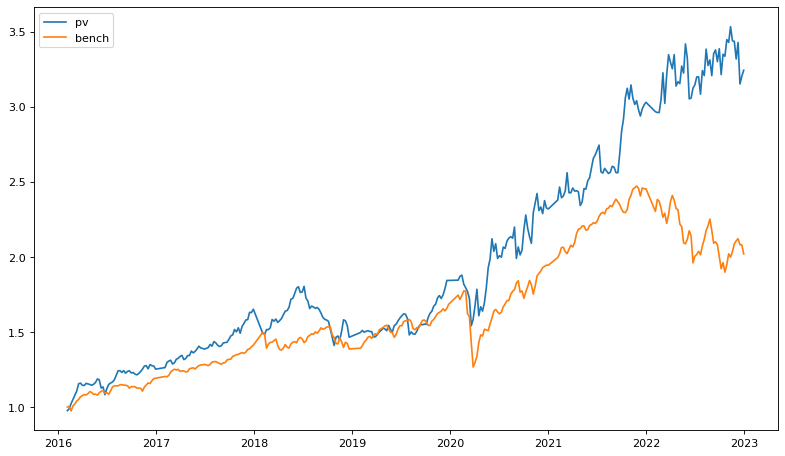

In [27]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [28]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,0.983971,0.920404,1.028121,0.990055,0.964944,0.930128,0.925247,1.005504,1.004430,1.012687,2016,5,0.976549,1899.45,1.000000,2016-W5,2016-02-05
1,0.986428,0.911947,1.059629,0.995188,0.952413,0.995974,0.965968,1.005504,1.004430,1.012687,2016,6,0.989017,1910.09,1.005602,2016-W6,2016-02-12
2,1.006367,0.936543,1.138784,1.023974,0.978395,1.045603,0.965322,1.032743,1.077385,1.032354,2016,7,1.023747,1850.27,0.974108,2016-W7,2016-02-19
3,1.067014,1.026598,1.158367,0.925829,1.073428,1.053353,0.993861,1.056150,1.128698,1.035337,2016,8,1.051863,1914.50,1.007923,2016-W8,2016-02-26
4,1.288392,1.037643,1.147712,0.912620,1.035764,1.101571,1.063459,1.037779,1.095606,1.093481,2016,9,1.081403,1939.26,1.020959,2016-W9,2016-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.823010,1.309684,2.733000,2.174999,4.007778,1.923857,2.482479,9.800428,6.571645,1.351555,2022,48,3.317844,4001.73,2.106784,2022-W48,2022-12-02
331,0.884038,1.342785,2.743264,2.290437,4.148518,1.985917,2.660270,10.049413,6.664103,1.510729,2022,49,3.427947,4029.99,2.121662,2022-W49,2022-12-09
332,0.867847,1.210290,2.332199,2.096606,3.687572,1.926852,2.547422,9.097852,6.419943,1.325613,2022,50,3.151220,3954.38,2.081855,2022-W50,2022-12-16
333,0.913960,1.235973,2.427146,2.089975,3.707744,1.930422,2.624678,9.205710,6.541926,1.352423,2022,51,3.202996,3950.73,2.079934,2022-W51,2022-12-23


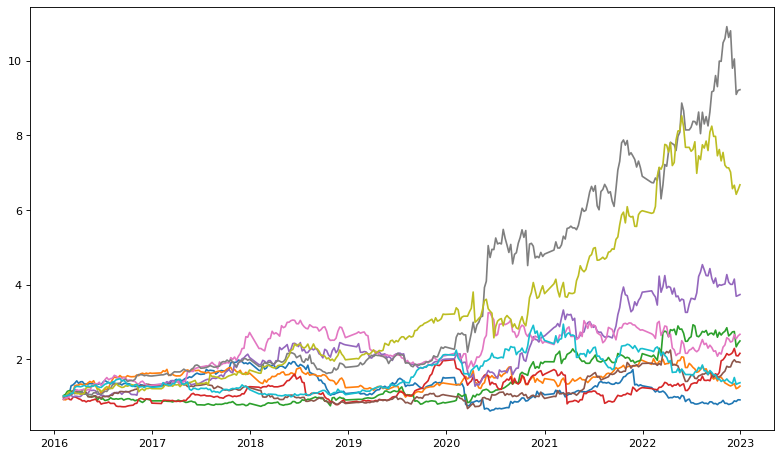

In [29]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [30]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Health Care,2019.076828,28.843866,0.054874,1.0,1.006864,9.462206
Communication Services,2018.905128,29.697436,0.054354,1.0,1.006862,9.212821
Information Technology,2018.882248,28.066012,0.057244,1.0,1.005925,9.959857
Energy,2019.251572,28.968553,0.062896,1.0,1.005847,9.169811
Materials,2019.011173,28.290503,0.056501,1.0,1.005345,9.779330
Consumer Discretionary,2018.946627,28.676798,0.094354,1.0,1.004692,6.901408
Financials,2019.142857,30.091071,0.050550,1.0,1.003849,10.692857
Industrials,2018.959438,28.394696,0.048877,1.0,1.003694,10.951638
Real Estate,2018.680851,28.141844,0.042474,1.0,1.003541,10.726950


In [31]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  \
year week ticker Security                                      
2020 5    TSLA   Tesla, Inc.                        0.003217   
2021 28   MRNA   Moderna                            0.031984   
2018 44   ENPH   Enphase                            0.087856   
2020 21   PENN   Penn National Gaming               0.140409   
2022 11   EPAM   EPAM Systems                       0.084177   
2020 35   CRM    Salesforce                         0.026422   
     20   PENN   Penn National Gaming               0.122029   
     21   CZR    Caesars Entertainment              0.157287   
     35   TSLA   Tesla, Inc.                        0.177993   
     23   DVN    Devon Energy                       0.074319   
          HAL    Halliburton                        0.075408   
2022 45   ETSY   Etsy                               0.057630   
     9    OXY    Occidental Petroleum               0.101552   
2018 19   SEDG   SolarEdge                          0.053557   
2021 6    TWTR   Twitter Inc.                       0.071931   
2017 31   SEDG   SolarEdge                          0.036300   
2020 40   ENPH   Enphase                            0.086309   
2022 17   WDC    Western Digital                    0.022760   
2020 5    PENN   Penn National Gaming               0.003623   
2016 9    FCX    Freeport-McMoRan                   0.144796   
     45   REGN   Regeneron                          0.073627   
2020 23   CZR    Caesars Entertainment              0.053968   
2016 33   NTAP   NetApp                             0.035204   
2020 21   RF     Regions Financial Corporation      0.123127   
     7    DXCM   Dexcom                             0.033336   
2021 21   MRO    Marathon Oil                       0.121742   
2020 7    ENPH   Enphase                            0.060833   
2021 47   MRNA   Moderna                            0.071890   
2019 43   LRCX   Lam Research                       0.017008   
2020 21   LNC    Lincoln Financial                  0.115412   

                                                weekly_delta_sign  \
year week ticker Security                                           
2020 5    TSLA   Tesla, Inc.                                  1.0   
2021 28   MRNA   Moderna                                      1.0   
2018 44   ENPH   Enphase                                      1.0   
2020 21   PENN   Penn National Gaming                         1.0   
2022 11   EPAM   EPAM Systems                                 1.0   
2020 35   CRM    Salesforce                                   1.0   
     20   PENN   Penn National Gaming                         1.0   
     21   CZR    Caesars Entertainment                        1.0   
     35   TSLA   Tesla, Inc.                                  1.0   
     23   DVN    Devon Energy                                 1.0   
          HAL    Halliburton                                  1.0   
2022 45   ETSY   Etsy                                         1.0   
     9    OXY    Occidental Petroleum                         1.0   
2018 19   SEDG   SolarEdge                                    1.0   
2021 6    TWTR   Twitter Inc.                                 1.0   
2017 31   SEDG   SolarEdge                                    1.0   
2020 40   ENPH   Enphase                                      1.0   
2022 17   WDC    Western Digital                              1.0   
2020 5    PENN   Penn National Gaming                         1.0   
2016 9    FCX    Freeport-McMoRan                             1.0   
     45   REGN   Regeneron                                    1.0   
2020 23   CZR    Caesars Entertainment                        1.0   
2016 33   NTAP   NetApp                                       1.0   
2020 21   RF     Regions Financial Corporation                1.0   
     7    DXCM   Dexcom                                       1.0   
2021 21   MRO    Marathon Oil                                 1.0   
2020 7    ENPH   Enphase                                      1.0  

In [32]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2016,5,1.000000,1.000000,0.960092,1.000000,1.000000,0.942674,0.968967,1.005504,0.994201,1.000000,1.028121
1,4064256,30,1.005184,1.002497,1.028058,0.990812,1.000000,0.977863,0.956383,1.005504,0.994201,1.000000,1.028121
2,8193540096,210,1.043784,1.034444,1.028058,1.026229,1.000000,1.025519,0.974956,1.048755,1.018723,1.009552,1.028121
3,16518176833536,1680,1.093496,1.087559,1.006506,1.026229,1.000000,1.028482,1.001828,1.077724,1.064724,1.009552,1.028121
4,33300644496408576,15120,1.142213,1.075729,1.006506,1.131144,1.000000,1.028482,1.047838,1.083176,1.136265,0.974129,1.028121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0,0,3.354503,2.284613,1.747321,4.024544,2.692430,8.307022,2.372198,8.590099,3.395337,1.447101,0.889449
331,0,0,3.495826,2.427200,1.778827,4.024544,2.786979,8.443713,2.445638,8.694086,3.395337,1.461356,0.889449
332,0,0,2.971993,2.264082,1.730754,4.024544,2.668756,8.035209,2.356661,7.882995,3.395337,1.461356,0.857225
333,0,0,3.014875,2.335461,1.751273,4.024544,2.721356,8.320613,2.369552,7.897604,3.395337,1.461356,0.857225
